# 2D_TMDでの線形・非線形応答

In [1]:
using Distributed
addprocs(30)

30-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
  ⋮
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31

In [2]:
#Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
@everywhere struct Parm
    t_i::Float64
    a_u::Float64
    a_d::Float64
    Pr::Float64
    mu::Float64
    eta::Float64
    T::Float64
    hx::Float64
    hy::Float64
    hz::Float64
    K_SIZE::Int
    W_MAX::Float64
    W_SIZE::Int
end

@everywhere mutable struct Hamiltonian
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vxy::Array{ComplexF64,2}
    Vyy::Array{ComplexF64,2}
    E::Array{ComplexF64,1}
end

@everywhere mutable struct Green
    GR::Array{ComplexF64,2}
    GA::Array{ComplexF64,2}
    GRmA::Array{ComplexF64,2}
    dGR::Array{ComplexF64,2}
end

In [3]:
@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    
    return GR, GA, GRmA, dGR
end

@everywhere a1 = [1.0, 0.0]
@everywhere a2 = [-0.5, sqrt(3.0)/2]
@everywhere a3 = [0.5, sqrt(3.0)/2]
@everywhere sigma = [[1.0 0.0; 0.0 1.0], [0.0 1.0; 1.0 0.0], [0.0 -1.0im; 1.0im 0.0], [1.0 0.0; 0.0 -1.0]]


@everywhere function HandV(k0::NTuple{2, Float64},p::Parm)
    k = [k0[1], k0[1]]
    eps::Float64 = 2.0p.t_i*(p.Pr*cos(k'*a1) + cos(k'*a2) + cos(k'*a3)) + p.mu
    g_x::Float64 = p.a_u*(sin(k'*a3) + sin(k'*a2))/2 - p.hx
    g_y::Float64 = -p.a_u * (sin(k'*a1) + (sin(k'*a3) - sin(k'*a2))/2)/sqrt(3.0) - p.hy
    g_z::Float64 = 2p.a_d*(sin(k'*a1) + sin(k'*a2) - sin(k'*a3))/(3.0*sqrt(3.0)) - p.hz
    gg = [eps, g_x, g_y, g_z]
    H::Array{ComplexF64,2} =  gg' * sigma

    eps_vx::Float64 = 2.0p.t_i*(-p.Pr*sin(k'*a1) + 0.5sin(k'*a2) - 0.5sin(k'*a3))
    gx_vx::Float64 = p.a_u*(cos(k'*a3) - cos(k'*a2))/4 
    gy_vx::Float64 = -p.a_u * (cos(k'*a1) + 0.5*(cos(k'*a3) + cos(k'*a2))/2)/sqrt(3.0)
    gz_vx::Float64 = 2p.a_d*(cos(k'*a1) - 0.5cos(k'*a2) - 0.5cos(k'*a3))/(3.0*sqrt(3.0))
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vx::Array{ComplexF64,2} = gg_x' * sigma

    eps_vy::Float64 = sqrt(3.0)*p.t_i*(-sin(k'*a2) - sin(k'*a3))
    gx_vy::Float64 = sqrt(3.0)*p.a_u*(cos(k'*a3) + cos(k'*a2))/4 
    gy_vy::Float64 = -p.a_u * ((cos(k'*a3) - cos(k'*a2))/4)
    gz_vy::Float64 = p.a_d*(cos(k'*a2) - cos(k'*a3))/(3.0)
    gg_y = [eps_vy, gx_vy, gy_vy, gz_vy]
    Vy::Array{ComplexF64,2} = gg_y' * sigma

    eps_vxx::Float64 = 2.0p.t_i*(-p.Pr*cos(k'*a1) - 0.25cos(k'*a2) - 0.25cos(k'*a3))
    gx_vxx::Float64 = p.a_u*(-sin(k'*a3) - sin(k'*a2))/8 
    gy_vxx::Float64 = -p.a_u * (-sin(k'*a1) + 0.25*(-sin(k'*a3) + sin(k'*a2))/2)/sqrt(3.0)
    gz_vxx::Float64 = 2p.a_d*(-sin(k'*a1) - 0.25sin(k'*a2) + 0.25sin(k'*a3))/(3.0*sqrt(3.0))
    gg_xx = [eps_vxx, gx_vxx, gy_vxx, gz_vxx]
    Vxx::Array{ComplexF64,2} = gg_xx' * sigma
    
    eps_vxy::Float64 = sqrt(3.0)*p.t_i*(cos(k'*a2) - cos(k'*a3))/2
    gx_vxy::Float64 = sqrt(3.0)*p.a_u*(-sin(k'*a3) + sin(k'*a2))/8 
    gy_vxy::Float64 = -p.a_u * ((-sin(k'*a3) - sin(k'*a2))/8)
    gz_vxy::Float64 = p.a_d*(sin(k'*a2) + sin(k'*a3))/(6.0)
    gg_xy = [eps_vxy, gx_vxy, gy_vxy, gz_vxy]
    Vxy::Array{ComplexF64,2} = gg_xy' * sigma

    eps_vyy::Float64 = 1.5*p.t_i*(-cos(k'*a2) - cos(k'*a3))
    gx_vyy::Float64 = 3.0*p.a_u*(-sin(k'*a3) - sin(k'*a2))/8 
    gy_vyy::Float64 = -p.a_u * sqrt(3.0) * ((-sin(k'*a3) + sin(k'*a2))/8)
    gz_vyy::Float64 = p.a_d*(-sin(k'*a2) + sin(k'*a3))/(2.0*sqrt(3.0))
    gg_yy = [eps_vyy, gx_vyy, gy_vyy, gz_vyy]
    Vyy::Array{ComplexF64,2} = gg_yy' * sigma

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vxx, Vxy, Vyy, E 
end

@everywhere function HV_BI(H::Hamiltonian)

    H.E, BI::Array{ComplexF64,2} = eigen(H.Hk)
    H.Hk = [H.E[1] 0.0; 0.0 H.E[2]]
    Vx_BI::Array{ComplexF64,2} = BI' * H.Vx * BI
    Vy_BI::Array{ComplexF64,2} = BI' * H.Vy * BI
    Vxx_BI::Array{ComplexF64,2} = BI' * H.Vxx * BI
    Vxy_BI::Array{ComplexF64,2} = BI' * H.Vxy * BI
    Vyy_BI::Array{ComplexF64,2} = BI' * H.Vyy * BI
    

    H.Vx = Vx_BI
    H.Vy = Vy_BI
    H.Vxx = Vxx_BI
    H.Vxy = Vxy_BI
    H.Vyy = Vyy_BI
end

In [39]:
println(kk[20])
(-2pi/3+dk/2, 2pi/sqrt(3.0)-sqrt(3)*dk/2)

(-1.9896753472735356, 3.4462187920450136)


(-1.9896753472735356, 3.446218792045014)

In [76]:
p0 = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.04, 0.06, 0.0, 0.0, 0.0, 20, 0.5, 1000)
#p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.04, 0.06, 0.0, 0.0, 0.0, K_SIZE, 0.5, 1000)
k_test = (4pi/3+dk, 0.0)
#println(kk[390])
H_test = Hamiltonian(HandV(k_test,p0)...)
HV_BI(H_test)
Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI(p0,H_test)
println(dk2*Drude0)

#p0 = Parm(0.5, -0.08, -0.06, 0.7, 0.7, 0.04, 0.05, 0.0, 0.0, 0.0, 100, 0.5, 1000)
k_test = -1.0.*k_test
H_test = Hamiltonian(HandV(k_test,p0)...)
HV_BI(H_test)
Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI(p0,H_test)
println(dk2*Drude0)


1.840846505232215e-8
-1.8408465052322083e-8


In [4]:
@everywhere f(e::Float64,T::Float64) = 1.0/(1.0+exp(e/T))
@everywhere df(e::Float64,T::Float64) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere f(e::ComplexF64,T::Float64) = 1.0/(1.0+exp(e/T))
@everywhere df(e::ComplexF64,T::Float64) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere function Green_YY_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    Drude0::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    app_QM::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude += -real(H.Vy[i,i]*H.Vy[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        Drude0 += -real(H.Vy[i,i]*H.Vy[i,i])*real(df(H.E[i], p.T))/(2.0p.eta)
        BC += 2.0*imag(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(f(H.E[i]+1.0im*p.eta, p.T))
        dQM += 2.0*real(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(f(H.E[i]+1.0im*p.eta, p.T))
        app_QM += 2.0*p.eta*real(H.Vy[i,3-i]*H.Vy[3-i,i])/((H.E[i]-H.E[3-i])^2+4.0*p.eta^2)*(-df(H.E[i], p.T))
    end
    return Drude, Drude0, BC, dQM, app_QM
end

@everywhere function Green_DC_2D(p::Parm, H::Hamiltonian)
    YY::Float64 = 0.0
    #dw::Float64 = p.W_MAX/p.W_SIZE/pi
    mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = mi/p.W_SIZE/pi
    for w in collect(-mi:2.0mi/p.W_SIZE:mi)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        YY += -real(tr(H.Vy*G.GR*H.Vy*G.GA))*df(w,p.T)
        #ZZ += -2.0real(tr(H.Vz*G.dGR*H.Vz*G.GR))*f(w,p.T)
    end
    return dw*YY
end

@everywhere function Green_YYY_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    #HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vy[i,i]*(H.Vy[i,i]*H.Vy[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        #Drude += 2.0*real(2.0*H.Vy[i,i]*H.Vy[i,i]*H.Vy[i,i])*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^3)
        #BCD += 2.0*real(2.0*H.Vy[i,i]* H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        #sQMD += 2.0*real(2.0*H.Vy[i,i]*H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        BCD += -4.0*imag(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -4.0*imag(2.0*H.Vy[i,i]*H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -4.0*real(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0real(H.Vy[i,3-i]*(2.0*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vyy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0imag(H.Vy[i,3-i]*(2.0*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vyy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_XXX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    #HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vx[i,i]*H.Vx[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        #Drude += 2.0*real(2.0*H.Vx[i,i]*H.Vx[i,i]*H.Vx[i,i])*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^3)
        #BCD += 2.0*real(2.0*H.Vx[i,i]* H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        #sQMD += 2.0*real(2.0*H.Vx[i,i]*H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        BCD += -4.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -4.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0real(H.Vx[i,3-i]*(2.0*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0imag(H.Vx[i,3-i]*(2.0*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_YYY(p::Parm, H::Hamiltonian)
    G0::Float64 = 0.0
    mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = mi/p.W_SIZE/pi
    for w in collect(-mi:2.0mi/p.W_SIZE:mi)
        G = Green(Gk(w,p,H)...)
        G0 += 2.0imag(tr(H.Vy*G.dGR*(2.0*H.Vy*G.GR*H.Vy + H.Vyy)*G.GRmA)*df(w,p.T))
    end
    return dw*G0
end

Tuple{Float64, Float64}[]

In [79]:
test = collect(0:0.1:1)
test[11]

1.0

In [95]:
K_SIZE = 400
kk = Vector{NTuple{2, Float64}}(undef,0)
dk = 4pi/(3K_SIZE)
dk2 = 2.0/(3*sqrt(3.0)*K_SIZE*K_SIZE)
for i in collect(dk:dk:4pi/3)
    
    for j in collect(0:dk:4pi/3)
        k = j*a1 + i*a2
        push!(kk,(k[1],k[2]))
    end
    
    
    for j in collect(dk:dk:4pi/3)
        if (i+j) < (4pi/3+dk)
            k = -j*a1 + i*a3
            push!(kk,(k[1],k[2]))
        end
    end
end
l = length(kk)

for i in 1:l
    k0 = kk[i]
    k0 = -1 .* k0
    push!(kk,k0)
end

for i in collect(-4pi/3:dk:4pi/3)
    k = i*a1
    push!(kk,(k[1],k[2]))
end

In [121]:
@everywhere using LinearAlgebra
#using DataFrames
#using CSV
#using Plots
mu0 = [0.002, 0.004, 0.006, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]
#[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]


DrudeX_mu = zeros(Float64,length(mu0))
Drude0_mu = zeros(Float64,length(mu0))
BCX_mu = zeros(Float64,length(mu0))
dQMX_mu = zeros(Float64,length(mu0))
app_QM_mu = zeros(Float64,length(mu0))
Green_mu = zeros(Float64,length(mu0))
#=
@everywhere using SharedArrays
Green_XXX_mu = SharedArray{Float64,1}(length(kk))
Drude_XXX_mu = SharedArray{Float64,1}(length(kk))
BCD_XXX_mu = SharedArray{Float64,1}(length(kk))
sQMD_XXX_mu = SharedArray{Float64,1}(length(kk))
dQMD_XXX_mu = SharedArray{Float64,1}(length(kk))
Inter_XXX_mu = SharedArray{Float64,1}(length(kk))
dInter_XXX_mu = SharedArray{Float64,1}(length(kk))
=#

Green_XXX_mu = zeros(Float64,length(mu0))
Drude_XXX_mu = zeros(Float64,length(mu0))
BCD_XXX_mu = zeros(Float64,length(mu0))
sQMD_XXX_mu = zeros(Float64,length(mu0))
dQMD_XXX_mu = zeros(Float64,length(mu0))
Inter_XXX_mu = zeros(Float64,length(mu0))
dInter_XXX_mu = zeros(Float64,length(mu0))


for j in 1:length(mu0)
    #Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
    p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.01, mu0[j], 0.0, 0.0, 0.0, K_SIZE, 0.5, 1000)
    #p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.04, 0.06, 0.0, 0.0, 0.0, K_SIZE, 0.5, 1000)
    
    if j == 1
        println("Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)")
        println(p)
    end

    #k2 = collect(Iterators.product((-pi:2pi/p.K_SIZE:pi)[1:end-1], (-pi:2pi/p.K_SIZE:pi)[1:end-1]))

    #, Green_mu[j], Drude_XXX_mu[j], BCD_XXX_mu[j], sQMD_XXX_mu[j], dQMD_XXX_mu[j], Inter_XXX_mu[j], dInter_XXX_mu[j], Green_XXX_mu[j]
    #DrudeX_mu[j], Drude0_mu[j], BCX_mu[j], dQMX_mu[j], app_QM_mu[j], Drude_XXX_mu[j], BCD_XXX_mu[j], sQMD_XXX_mu[j], dQMD_XXX_mu[j], Inter_XXX_mu[j], dInter_XXX_mu[j] = @distributed (+) for i in 1:length(kk)
    DrudeX_mu[j], Drude0_mu[j], BCX_mu[j], dQMX_mu[j], app_QM_mu[j], Green_mu[j] = @distributed (+) for i in 1:length(kk)
    #@sync @distributed for i in 1:length(kk)
        Hamk = Hamiltonian(HandV(kk[i],p)...)
        Green = Green_DC_2D(p, Hamk)
        #Green_NL = Green_YYY(p,Hamk)
        Dr, Dr_0, BC, dQM, app_QM = Green_YY_BI(p,Hamk)
        #HV_BI(Hamk)
        #Drude_XXX_mu[i], BCD_XXX_mu[i], sQMD_XXX_mu[i], dQMD_XXX_mu[i], Inter_XXX_mu[i], dInter_XXX_mu[i] = Green_XXX_BI(p,Hamk)
        #Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_YYY_BI(p,Hamk)
        #if i == 390
        #    println(kk[i])
        #    println(Drude_XXX_mu[i])
        #end
        [dk2*Dr, dk2*Dr_0, dk2*BC, dk2*dQM, dk2*app_QM, dk2*Green]
        #, dk2*Green, dk2*Drude0, dk2*BCD0, dk2*sQMD0, dk2*dQMD0, dk2*Inter0, dk2*dInter0, dk2*Green_NL
        ##[dk2*Dr, dk2*Dr_0, dk2*BC, dk2*dQM, dk2*app_QM, dk2*Drude0, dk2*BCD0, dk2*sQMD0, dk2*dQMD0, dk2*Inter0, dk2*dInter0]
    end
end
println("finish the calculation!")
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成

save_data = DataFrame(mu=mu0, Drude=DrudeX_mu, BC=BCX_mu, dQM=dQMX_mu, Drude0=Drude0_mu, app_QM=app_QM_mu, Green=Green_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./T_dep_eta001_YY.csv", save_data)
#using DataFrames
#using CSV
#save_data2 = DataFrame(mu=mu0, Drude=Drude_XXX_mu, BCD=BCD_XXX_mu, sQMD=sQMD_XXX_mu, dQMD=dQMD_XXX_mu, Inter=Inter_XXX_mu, dInter=dInter_XXX_mu, Green=Green_XXX_mu)
#CSV.write("./Tdep_eta=001_YYY.csv", save_data2)


#gr()


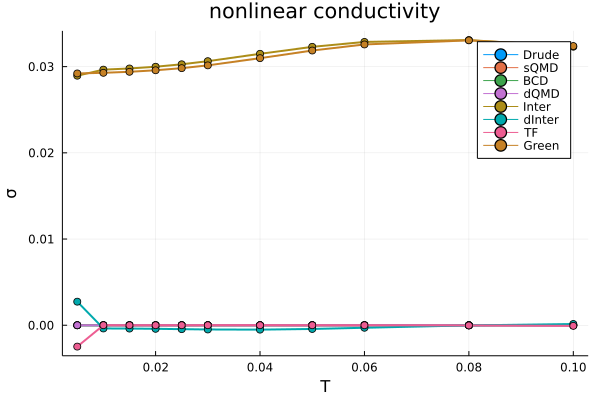

In [119]:
plot(mu0, Drude_XXX_mu, label="Drude",xlabel="T",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, Inter_XXX_mu, label="Inter", width=2.0, marker=:circle)
plot!(mu0, dInter_XXX_mu, label="dInter", width=2.0, marker=:circle)
plot!(mu0, -Green_XXX_mu-(Drude_XXX_mu+sQMD_XXX_mu+BCD_XXX_mu+dQMD_XXX_mu+Inter_XXX_mu+dInter_XXX_mu), label="TF", width=2.0, marker=:circle)
plot!(mu0, -Green_XXX_mu, label="Green", width=2.0, marker=:circle)

In [102]:
#=
ENV["GKSwstype"]="nul"
p1=plot(mu0, DrudeX_mu, label="Drude",xlabel="T",ylabel="σ",title="linear conductivity", width=2.0, marker=:circle)
p1=plot!(mu0, BCX_mu+dQMX_mu, label="sQM", width=2.0, marker=:circle)
#p1=plot!(mu0, Green_mu-DrudeX_mu-BCX_mu-dQMX_mu, label="TF", width=2.0, marker=:circle)
#p1=plot!(mu0, Green_mu, label="Green", width=2.0, marker=:circle)
savefig(p1,"./T_dep_ZZ.png")
=#
#p2=plot(mu0, Drude_XXX_mu, label="Drude",xlabel="T",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
#p2=plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
#p2=plot!(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#p2=plot!(mu0, dQMD_XXX_mu, label="dQMD", width=2.0, marker=:circle)
#p2=plot!(mu0, Green_XXX_mu, label="Green", width=2.0, marker=:circle)
#savefig(p2,"./T_dep_XXX.png")
#plot(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, dQMD_XXX_mu+BCD_XXX_mu, label="sum_TR", width=2.0, marker=:circle)
p2=plot(mu0, Drude_XXX_mu+sQMD_XXX_mu+BCD_XXX_mu+dQMD_XXX_mu+Inter_XXX_mu+dInter_XXX_mu, label="band_sum",xlabel="T",ylabel="σ",title="NRC", width=2.0, marker=:circle)
p2=plot!(mu0, -Green_XXX_mu-(Drude_XXX_mu+sQMD_XXX_mu+BCD_XXX_mu+dQMD_XXX_mu+Inter_XXX_mu+dInter_XXX_mu), label="TF", width=2.0, marker=:circle)
p2=plot!(mu0, -Green_XXX_mu, label="Green", width=2.0, marker=:circle)
#plot!(mu0, total_XXX_mu, label="total", width=2.0, marker=:circle)
savefig(p2,"./T_dep_XXX2.png")

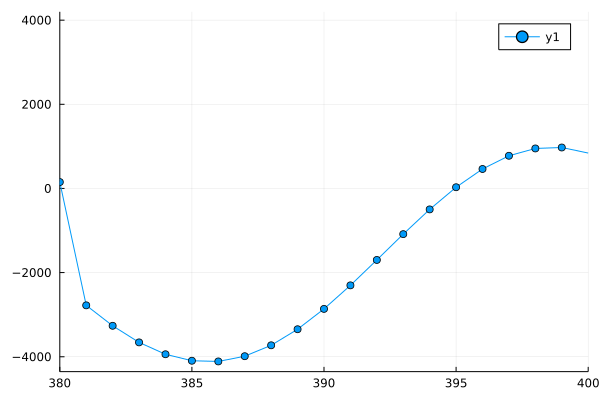

In [57]:
#ENV["GKSwstype"]="GR"
#using Plots
plot(Drude_XXX_mu, xrange=(380,400), marker=:circle)
#plot((kk[:]...,Drude_XXX_mu),st=:scatter,title="scatter",label="exp(-x)")